# Finite Difference Method

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Add the path to the mlmc module to the python path
sys.path.append("../py_mlmc")
from contract import EuropeanCall, EuropeanPut
from fdm import EuropeanFDM
from model import BlackScholes

In [2]:
# Model parameters
interest_rate = 0.05
initial_value = np.array([1.0])
sigma = 0.2

model = BlackScholes(interest_rate, initial_value, sigma)

# Contract parameters
maturity = 1.0
strike = 1.0

PDE for European options (in Black-Scholes model) with payoff $G(S_T)$:

$$
\begin{cases}
    \partial_t v+\frac{1}{2}\sigma^2 x^2 \partial^2_x v + rx \partial_x v - rv = 0 &\text{in } [0,T)\times[0,x_{max}) \\
    v(T,x) = G(x) &\text{in } [0,x_{max})
\end{cases}
$$

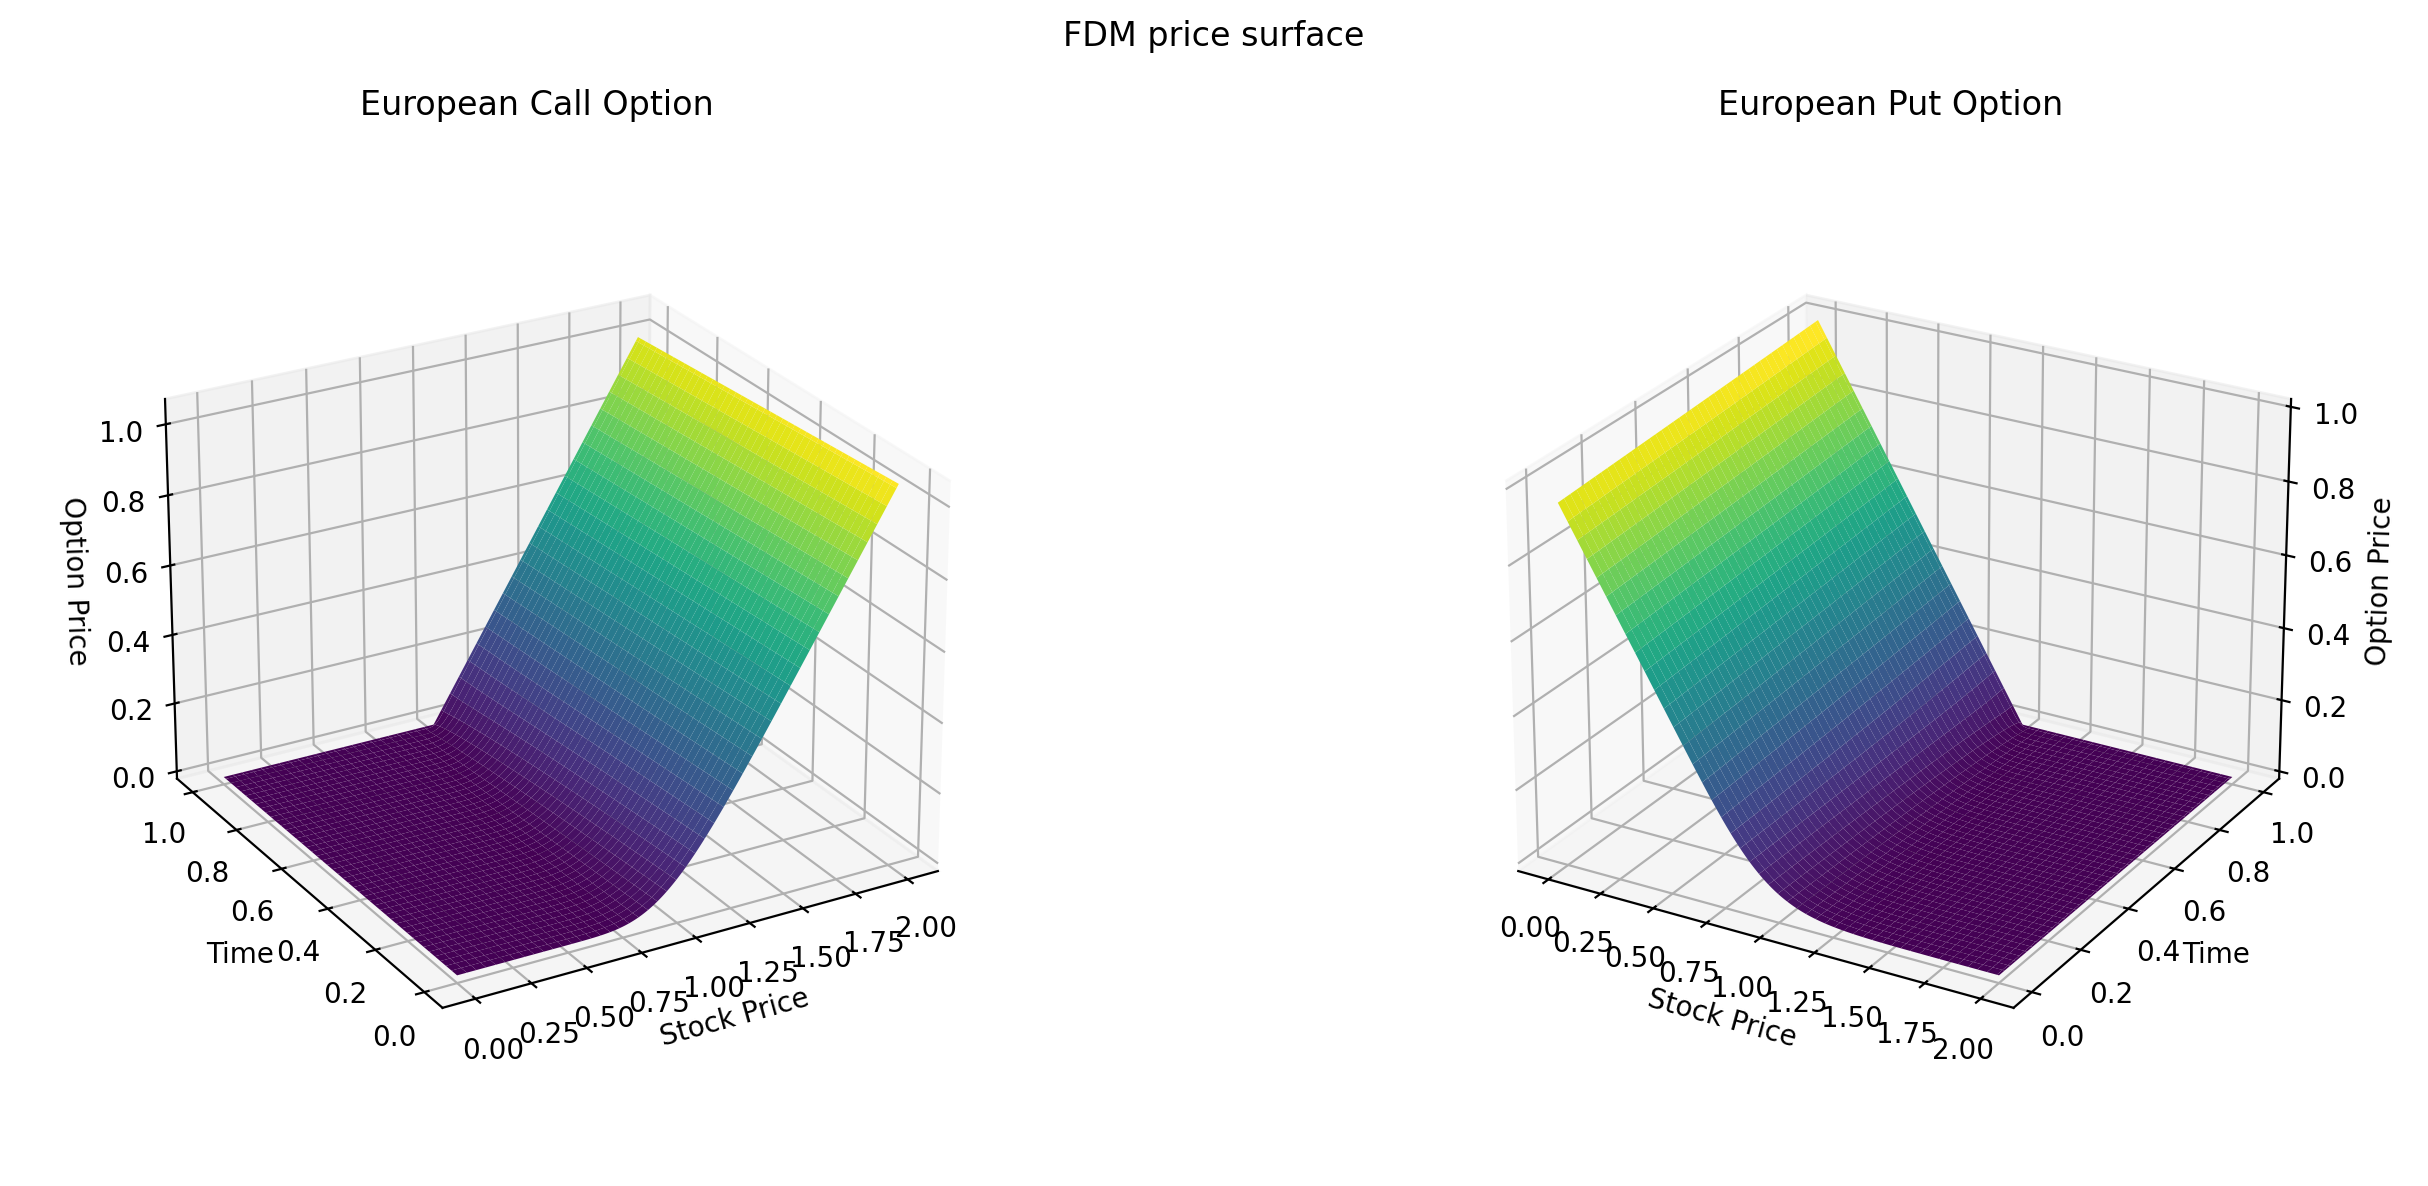

In [3]:
ue_fdm = EuropeanFDM(l=600, m=400)
xmin, xmax = 0, 2 * model.initial_value[0]

fig = plt.figure(figsize=(14, 6), dpi=200)

# Call
ue_call = EuropeanCall(maturity, strike)
boundary_min = 0
boundary_max = xmax - ue_call.strike * np.exp(
    -model.interest_rate * (ue_call.maturity - np.linspace(0, ue_call.maturity, ue_fdm.m))
)
t, x, u = ue_fdm.solve(model, ue_call, xmin, xmax, boundary_min, boundary_max)
t_grid, x_grid = np.meshgrid(t, x)

ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_surface(x_grid, t_grid, u, cmap="viridis")
ax1.set_title("European Call Option")
ax1.set_xlabel("Stock Price")
ax1.set_ylabel("Time")
ax1.set_zlabel("Option Price")
ax1.view_init(elev=25, azim=-120)
ax1.set_box_aspect(None, zoom=0.85)

# Put
ue_put = EuropeanPut(maturity, strike)
boundary_min = ue_call.strike * np.exp(
    -model.interest_rate * (ue_call.maturity - np.linspace(0, ue_call.maturity, ue_fdm.m))
)
boundary_max = 0
t, x, u = ue_fdm.solve(model, ue_put, xmin, xmax, boundary_min, boundary_max)

t_grid, x_grid = np.meshgrid(t, x)
ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(x_grid, t_grid, u, cmap="viridis")
ax2.set_title("European Put Option")
ax2.set_xlabel("Stock Price")
ax2.set_ylabel("Time")
ax2.set_zlabel("Option Price")
ax2.view_init(elev=25, azim=-60)
ax2.set_box_aspect(None, zoom=0.85)

fig.suptitle("FDM price surface")

plt.tight_layout()
plt.show()

In [4]:
def bs_price_surface(
    x_grid: np.ndarray,
    t_grid: np.ndarray,
    strike: float,
    interest_rate: float,
    sigma: float,
    payoff: str = "call",
) -> np.ndarray:
    bs_prices = np.zeros_like(x_grid, dtype=float)
    mask_t0 = t_grid == 0
    if payoff.lower() == "call":
        bs_prices[mask_t0] = np.maximum(x_grid[mask_t0] - strike, 0.0)
    else:
        bs_prices[mask_t0] = np.maximum(strike - x_grid[mask_t0], 0.0)

    mask_s0 = x_grid == 0
    if payoff.lower() == "put":
        bs_prices[mask_s0] = strike * np.exp(-interest_rate * t_grid[mask_s0])

    mask_valid = (t_grid > 0) & (x_grid > 0)
    s = x_grid[mask_valid]
    t = t_grid[mask_valid]

    sqrt_t = np.sqrt(t)
    d1 = (np.log(s / strike) + (interest_rate + 0.5 * sigma**2) * t) / (sigma * sqrt_t)
    d2 = d1 - sigma * sqrt_t

    if payoff.lower() == "call":
        bs_prices[mask_valid] = s * norm.cdf(d1) - strike * np.exp(-interest_rate * t) * norm.cdf(d2)
    else:
        bs_prices[mask_valid] = strike * np.exp(-interest_rate * t) * norm.cdf(-d2) - s * norm.cdf(-d1)

    return bs_prices

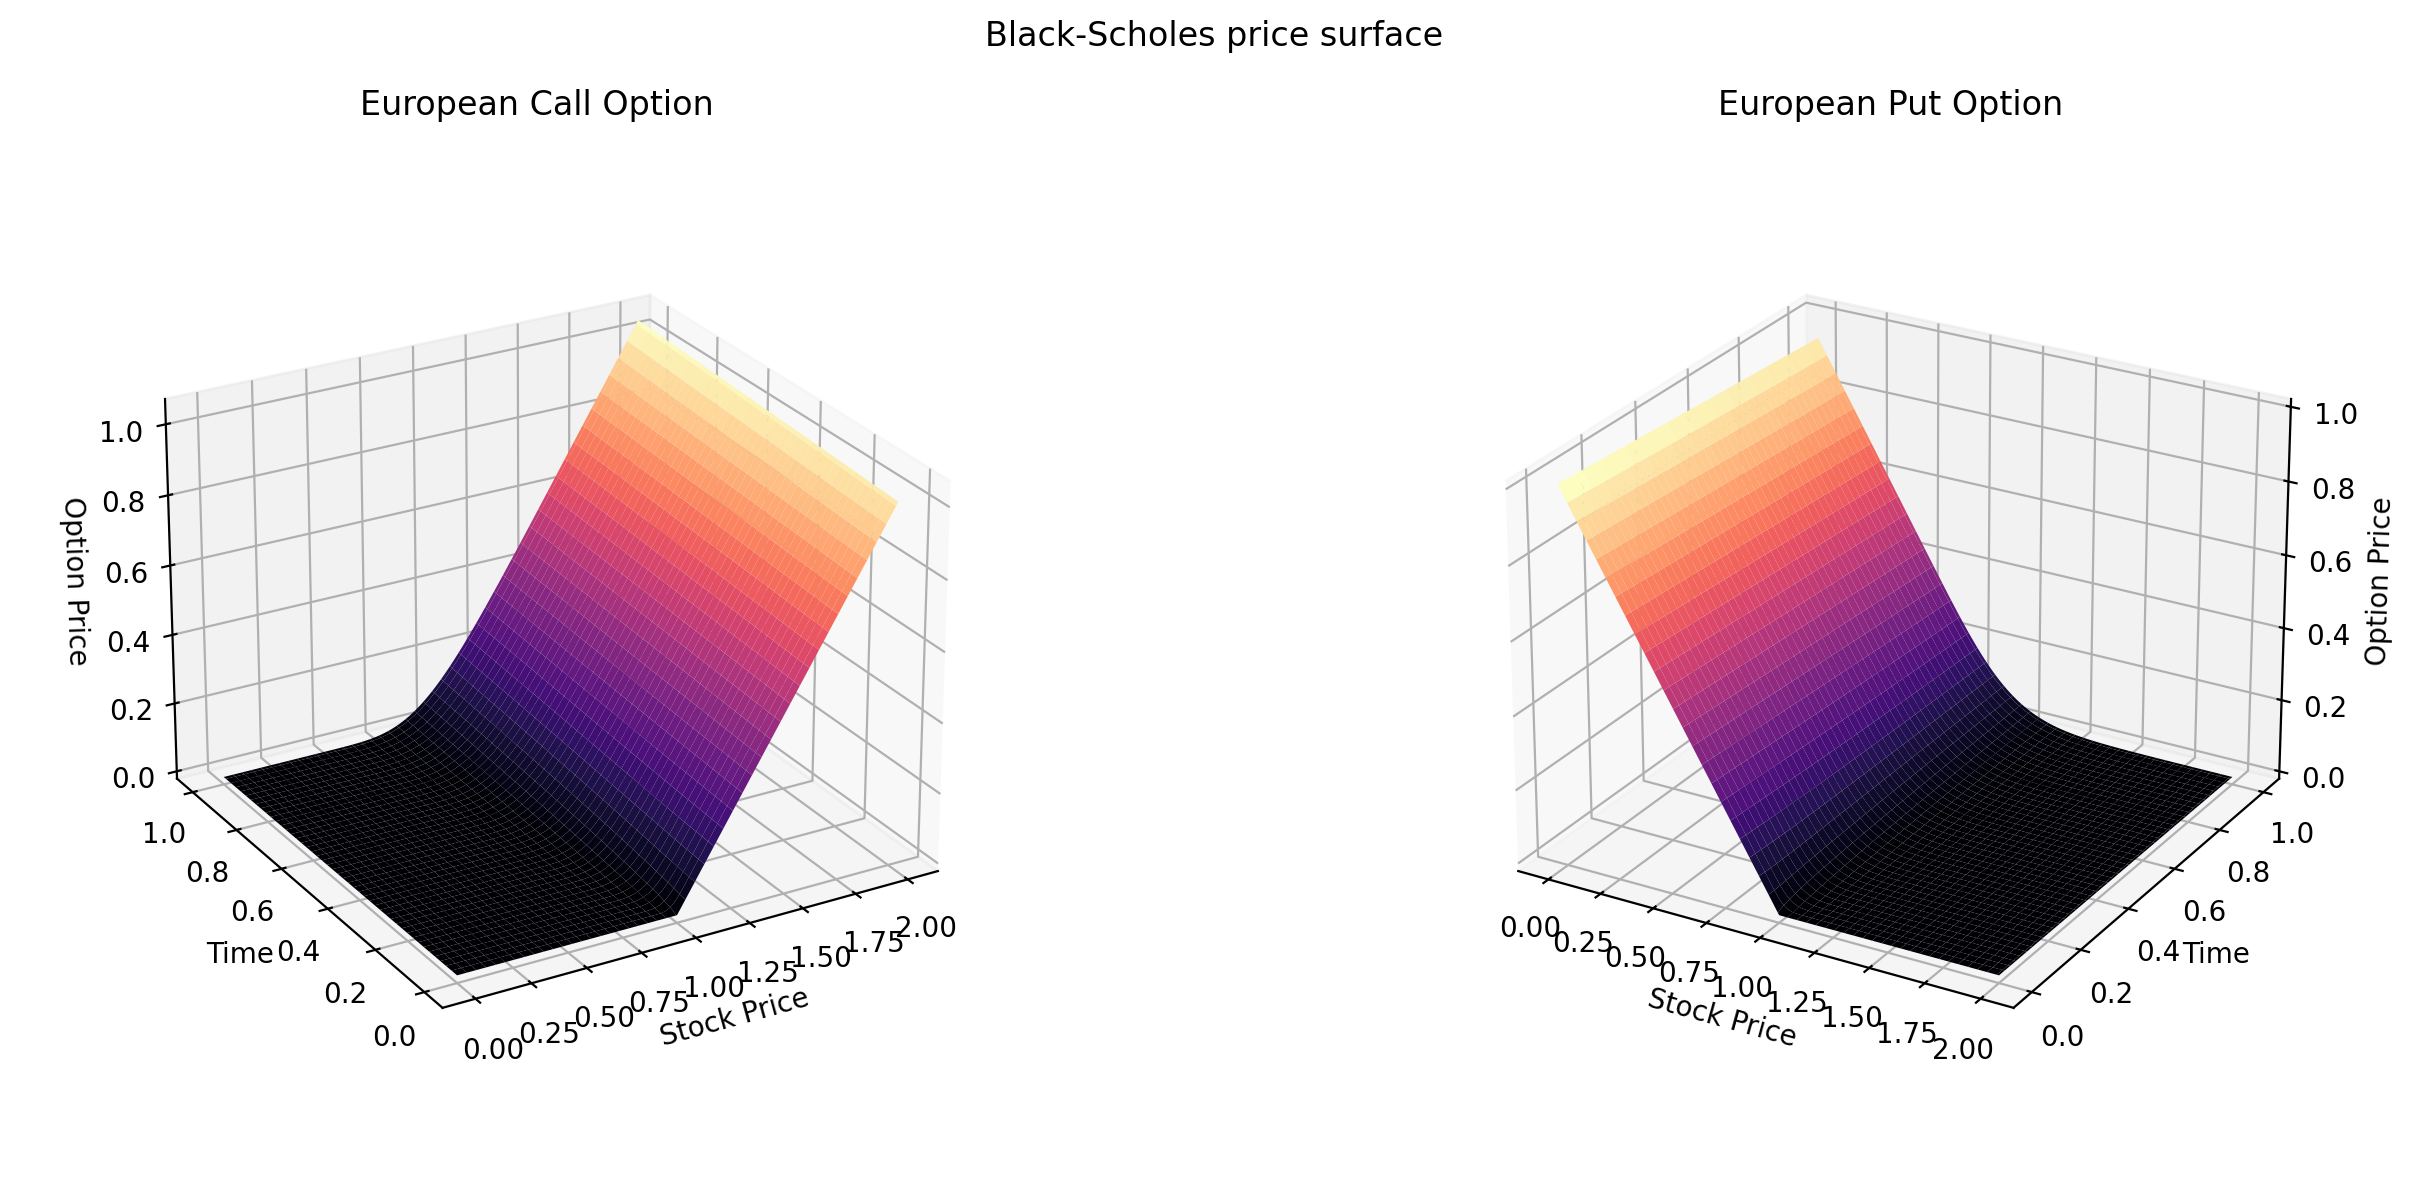

In [5]:
l, m = 600, 400
xmin, xmax = 0, 2 * model.initial_value

x = np.linspace(xmin, xmax, l + 2)
t = np.linspace(0, maturity, m + 1)
t_grid, x_grid = np.meshgrid(t, x)

fig = plt.figure(figsize=(14, 6), dpi=200)

# Call
bs_prices = bs_price_surface(x_grid, t_grid, strike, model.interest_rate, model.sigma, payoff="call")

ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_surface(x_grid, t_grid, bs_prices, cmap="magma")
ax1.set_title("European Call Option")
ax1.set_xlabel("Stock Price")
ax1.set_ylabel("Time")
ax1.set_zlabel("Option Price")
ax1.view_init(elev=25, azim=-120)
ax1.set_box_aspect(None, zoom=0.85)

# Put
bs_prices = bs_price_surface(x_grid, t_grid, strike, model.interest_rate, model.sigma, payoff="put")

ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(x_grid, t_grid, bs_prices, cmap="magma")
ax2.set_title("European Put Option")
ax2.set_xlabel("Stock Price")
ax2.set_ylabel("Time")
ax2.set_zlabel("Option Price")
ax2.view_init(elev=25, azim=-60)
ax2.set_box_aspect(None, zoom=0.85)

fig.suptitle("Black-Scholes price surface")

plt.tight_layout()
plt.show()

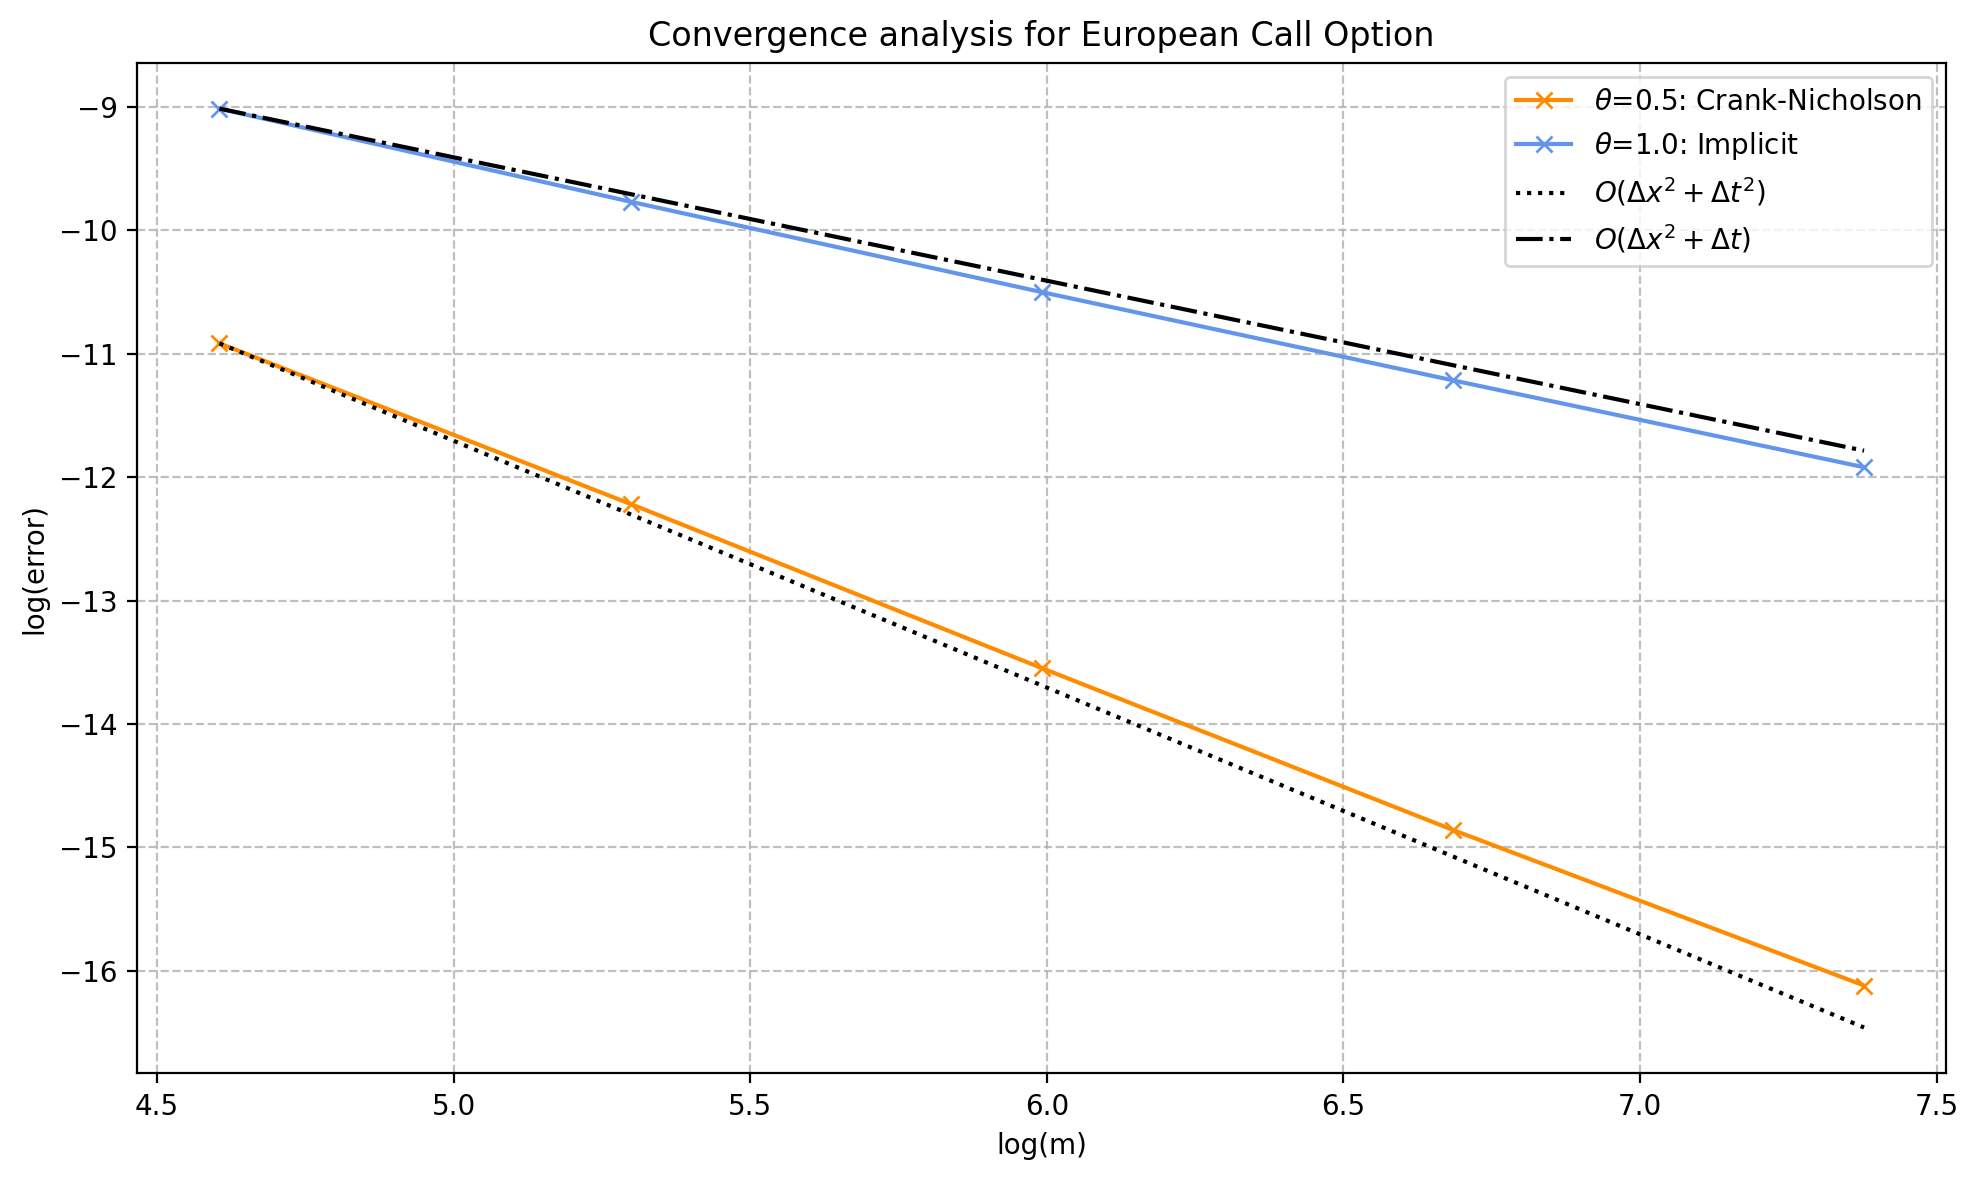

In [7]:
xmin, xmax = 0.0, 2.0 * model.initial_value[0]

ls = np.array([50, 100, 200, 400, 800])
ms = np.array([100, 200, 400, 800, 1600])

ue_call = EuropeanCall(maturity, strike)

thetas = [0.5, 1.0]
scheme_names = ["Crank-Nicholson", "Implicit"]
colors = ["darkorange", "cornflowerblue"]

plt.figure(figsize=(10, 6), dpi=200)

anchors = []
for theta, scheme_name, c in zip(thetas, scheme_names, colors):
    errors = np.zeros(len(ls))
    for i, (l, m) in enumerate(zip(ls, ms)):
        boundary_min = 0.0
        boundary_max = xmax - strike * np.exp(
            -model.interest_rate * (ue_call.maturity - np.linspace(0, ue_call.maturity, m))
        )

        ue_fdm = EuropeanFDM(l, m)
        t, x, u = ue_fdm.solve(model, ue_call, xmin, xmax, boundary_min, boundary_max, theta)

        t_grid, x_grid = np.meshgrid(t, x)
        bs_prices = bs_price_surface(x_grid, t_grid, strike, model.interest_rate, model.sigma)[:, ::-1]

        error = np.abs(bs_prices[:, 0] - u[:, 0])
        errors[i] = np.interp(initial_value[0], x, error)

    order = (np.log(errors[-1]) - np.log(errors[0])) / (np.log(ms[0]) - np.log(ms[-1]))
    anchors.append(errors[0])
    plt.plot(np.log(ms), np.log(errors), marker="x", c=c, label=f"$\\theta$={theta}: {scheme_name}")

plt.plot(np.log(ms), np.log(anchors[0] * ms[0] ** 2 / ms**2), ":", c="black", label=r"$O(\Delta x^2 + \Delta t^2)$")
plt.plot(np.log(ms), np.log(anchors[1] * ms[0] / ms), "-.", c="black", label=r"$O(\Delta x^2 + \Delta t)$")

plt.xlabel("log(m)")
plt.ylabel("log(error)")
plt.title("Convergence analysis for European Call Option")
plt.grid(True, linestyle="--", alpha=0.8)
plt.legend()
plt.tight_layout()
plt.show()